In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision

In [ ]:
try:
  Dataset = datasets.Caltech101('/content/101_ObjectCategories', download=True, transform= transforms.ToTensor())
except:
  print('No se pudo descargar de la pagina oficial')
  # aqui habría que poner un metodo para que lo lea de drive

import numpy as np
import math
from typing import List
import os
import argparse
import glob
import shutil

def list_files(path):
    files = os.listdir(path)
    return np.asarray(files)

def split_files(oldpath, newpath, classes):
    for name in classes:
        full_dir = os.path.join(os.getcwd(), f"{oldpath}/{name}")

        files = list_files(full_dir)
        total_file = np.size(files,0)
        # We split data set into 3: train, validation and test

        train_size = math.ceil(total_file * 3/4) # 75% for training 

        validation_size = train_size + math.ceil(total_file * 1/8) # 12.5% for validation
        test_size = validation_size + math.ceil(total_file * 1/8) # 12.5x% for testing 

        train = files[0:train_size]
        validation = files[train_size:validation_size]
        test = files[validation_size:]

        move_files(train, full_dir, f"train/{name}")
        move_files(validation, full_dir, f"validation/{name}")
        move_files(test, full_dir, f"test/{name}")

def move_files(files, old_dir, new_dir):
    new_dir = os.path.join(os.getcwd(), new_dir);
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

    for file in np.nditer(files):
        old_file_path = os.path.join(os.getcwd(), f"{old_dir}/{file}")
        new_file_path = os.path.join(os.getcwd(), f"{new_dir}/{file}")

        shutil.move(old_file_path, new_file_path)


      
classes = list(Dataset.categories)
print(len(classes))
split_files('101_ObjectCategories/caltech101/101_ObjectCategories', './', classes)

0it [00:00, ?it/s]

Extracting /content/101_ObjectCategories/caltech101/101_ObjectCategories.tar.gz to /content/101_ObjectCategories/caltech101


0it [00:00, ?it/s]

Extracting /content/101_ObjectCategories/caltech101/101_Annotations.tar to /content/101_ObjectCategories/caltech101
101


In [ ]:
transformations = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.PILToTensor()])
data = {
    'train': datasets.ImageFolder(root='./train', transform= transformations),
    'validation': datasets.ImageFolder(root='./validation', transform= transformations),
    'test': datasets.ImageFolder(root='./test', transform= transformations)
}

# create a data loader instance with each dataset with a batch size of 10 and shuffling
batch_size = 32
train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
validation_data = DataLoader(data['validation'], batch_size=batch_size, shuffle=True)
test_data = DataLoader(data['test'], batch_size=batch_size, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MyNetBig(nn.Module):
 def __init__(self, nclasses):
  super(MyNetBig, self).__init__()
  self.nclasses = nclasses
  self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
  self.bn1 = nn.BatchNorm2d(64)

  self.conv2 = nn.Conv2d(64, 64, 3, padding = 1)
  self.bn2 = nn.BatchNorm2d(64) 

  self.pol1 = nn.MaxPool2d(2,stride=2)

  self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
  self.bn3 = nn.BatchNorm2d(128)

  self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
  self.bn4 = nn.BatchNorm2d(128) 

  self.pol2 = nn.MaxPool2d(2,stride=2)

  self.fc1 = nn.Linear(100352,128)
  self.bn9 = nn.BatchNorm1d(128)

  self.fc2 = nn.Linear(128,256)
  self.bn10 = nn.BatchNorm1d(256)

  self.fc3 = nn.Linear(256,512)
  self.bn11 = nn.BatchNorm1d(512)

  self.fc4 = nn.Linear(512,1024)
  self.bn12 = nn.BatchNorm1d(1024)

  self.fc5 = nn.Linear(1024,self.nclasses)

 def forward(self, x):
  x = self.bn1(F.relu(self.conv1(x)))
  x = self.bn2(F.relu(self.conv2(x)))  
  x = F.max_pool2d(x, 2, stride=2)
  x = self.bn3(F.relu(self.conv3(x))) 
  x = self.bn4(F.relu(self.conv4(x)))   
  x = F.max_pool2d(x, 2, stride=2)    
  x = F.max_pool2d(x, 2, stride=2)
  
  x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))  # Operación para realizar un flatten de 
                                      # para los datos
  x = self.bn9(F.relu(self.fc1(x)))
  x = self.bn10(F.relu(self.fc2(x)))
  x = self.bn11(F.relu(self.fc3(x)))
  x = self.bn12(F.relu(self.fc4(x)))     
  x = self.fc5(x)
  return x

In [ ]:
pretrained = True
if pretrained:
  !gdown https://drive.google.com/u/0/uc?id=1K0VaDorX5WKn6FunCm4fsnL59beXs6bw&export=download
  net = torch.load('/content/modelo-normal')

else:
  net = MyNetBig(101)  # Creación de la red con 10 clases

  net.cuda()  # Consideración para utilizar la GPU

  criterion = nn.CrossEntropyLoss() # Función de pérdida 

  optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) # Optimizador

Downloading...
From: https://drive.google.com/u/0/uc?id=1K0VaDorX5WKn6FunCm4fsnL59beXs6bw
To: /content/modelo-normal
100% 55.7M/55.7M [00:00<00:00, 118MB/s] 


In [ ]:
import time
import numpy as np


# Variables para calcular el número de predicciones correctas y el número total
# de predicciones
historical_train_acc = []
historical_train_loss = []
historical_val_acc = []
historical_val_loss = []

t_0 = time.time()
for epoch in range(20): # Para cada época
  correct_train = 0
  total_train = 0
  train_batches = 0
  train_loss = 0
  t_0 = time.time()
  for i, data in enumerate(train_data, 0): # Obtener batch
    labels = data[1].cuda()
    inputs = data[0].float().cuda()
    total_train += labels.size(0)
    optimizer.zero_grad() # Inicialización del optimizador
    outputs = net(inputs) # Se genera la predicción de las clases
    loss_train_temp = criterion(outputs, labels)  # Cálculo de loss
    train_loss += loss_train_temp.item()
    loss_train_temp.backward()  # Propagación del error
    optimizer.step()  # Aplicación del optimizador
    _, predicted = torch.max(outputs.data, 1) # Se guardan las predicciones  
    correct_train += (predicted == labels).sum().item() # Número de predicciones
                                                        # de entrenamiento
                                                        # correctas
    train_batches += 1

  correct_validation = 0
  total_validation = 0
  val_batches = 0
  val_loss = 0
  
  with torch.no_grad(): # Condición para no modificar la red y evaluar en el
                        # conjunto de validación
                     
    for i, data in enumerate(validation_data, 0): # Obtener batch
    # Los siguientes pasos son análogos al caso del conjunto de entrenamiento
      labels = data[1].cuda()
      inputs = data[0].float().cuda()
      total_validation += labels.size(0)
      outputs = net(inputs)
      loss_val_temp = criterion(outputs, labels)
      val_loss += loss_val_temp.item()
      _, predicted = torch.max(outputs.data, 1)  
      correct_validation += (predicted == labels).sum().item() # Número de predicciones
                                                        # de entrenamiento
                                                        # correctas
      val_batches += 1

  t_f = time.time()
  train_acc = correct_train/total_train
  train_loss = train_loss/train_batches
  val_acc = correct_validation/total_validation
  val_loss = val_loss/val_batches

  historical_train_acc += [train_acc]
  historical_train_loss += [train_loss]
  historical_val_acc  += [val_acc]
  historical_val_loss += [val_loss]
  print(f'Epoca {epoch}: Tiempo {t_f-t_0}, train accuracy: {train_acc}, train loss: {train_loss}, validation accuracy: {val_acc}, val loss: {val_loss}')


In [ ]:
torch.save(net, 'modelo-normal')

In [ ]:
from google.colab import files
files.download('/content/' + 'modelo-normal')

## Visualizando el aprendizaje

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

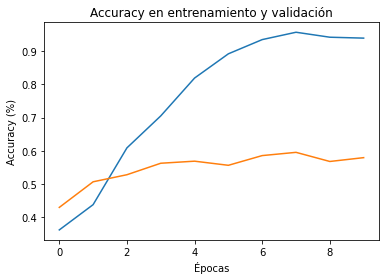

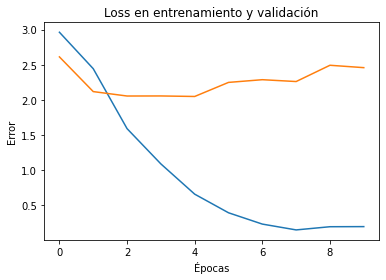

In [ ]:
epochs = [i for i in range(10)]

plt.plot(historical_train_acc)
plt.plot(historical_val_acc)
plt.title('Accuracy en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy (%)')
plt.show()

plt.plot(historical_train_loss)
plt.plot(historical_val_loss)
plt.title('Loss en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.show()

## Visualizando los resultados

# Entrenamiento adversario

In [ ]:
def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.float().to(device), y.to(device)
        delta = attack(model, X, y, **kwargs).to(device)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.float().to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [ ]:
if pretrained:
  !gdown https://drive.google.com/u/0/uc?id=1ueVBSgQuNyINzd81Atq6geYkdCIa-i8J&export=download
  model_cnn_robust  = torch.load('/content/modelo-adversario')

else:
  model_cnn_robust = MyNetBig(101)  # Creación de la red con 10 clases

  model_cnn_robust.cuda()  # Consideración para utilizar la GPU

  criterion = nn.CrossEntropyLoss() # Función de pérdida 

  optimizer = torch.optim.Adam(model_cnn_robust.parameters(), lr=1e-3) # Optimizador

Downloading...
From: https://drive.google.com/u/0/uc?id=1ueVBSgQuNyINzd81Atq6geYkdCIa-i8J
To: /content/modelo-adversario
100% 55.7M/55.7M [00:00<00:00, 107MB/s] 


In [ ]:
def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        output = model(X + delta)
        loss = nn.CrossEntropyLoss()(output, y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
device = 'cuda'
import time
historical_train_error, historical_test_error, historical_adv_error = [], [], []
for t in range(10):
    t_0 = time.time()
    train_err, train_loss = epoch_adversarial(train_data, model_cnn_robust, pgd_linf, optimizer)
    test_err, test_loss = epoch(validation_data, model_cnn_robust)
    adv_err, adv_loss = epoch_adversarial(test_data, model_cnn_robust, pgd_linf)
    if t == 4:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 1e-2
    t_f = time.time()
    historical_train_error += [train_err]
    historical_test_error += [test_err]
    historical_adv_error += [adv_err]
    print(f'-------------------------\n Epoca: {t}, tiempo: {t_f-t_0}')
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_cnn_robust.state_dict(), "model_cnn_robust.pt")

-------------------------
 Epoca: 0, tiempo: 1030.0584914684296
0.656136	0.579274	0.561245
-------------------------
 Epoca: 1, tiempo: 1031.1763243675232
0.523199	0.522586	0.494980
-------------------------
 Epoca: 2, tiempo: 1032.2281484603882
0.418193	0.479185	0.445783
-------------------------
 Epoca: 3, tiempo: 1034.233291387558
0.313797	0.460585	0.439759
-------------------------
 Epoca: 4, tiempo: 1033.2656977176666
0.229548	0.434898	0.425703
-------------------------
 Epoca: 5, tiempo: 1031.2393591403961
0.673535	0.627104	0.592369
-------------------------
 Epoca: 6, tiempo: 1030.5822699069977
0.552503	0.519929	0.510040
-------------------------
 Epoca: 7, tiempo: 1030.9822380542755
0.450244	0.489814	0.488956
-------------------------
 Epoca: 8, tiempo: 1029.9110572338104
0.357906	0.461470	0.444779
-------------------------
 Epoca: 9, tiempo: 1038.632614850998
0.254121	0.452613	0.461847


In [ ]:
train_loss = [0.656136, 0.523199, 0.418193, 0.313797, 0.229548, 0.673535, 0.552503, 0.450244, 0.357906, 0.254121]
test_loss = [0.579274, 0.522586, 0.479185, 0.460585, 0.434898, 0.627104, 0.519929, 0.489814, 0.461470, 0.45613]
adversarial_loss = [0.561245, 0.494980, 0.445783, 0.439759, 0.425703, 0.592369, 0.5510040, 0.488956, 0.444779, 0.491847]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

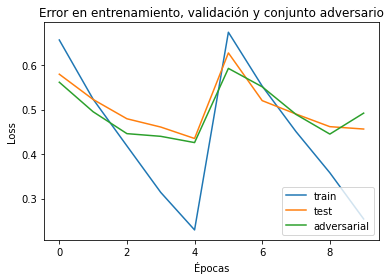

In [ ]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.plot(adversarial_loss, label='adversarial')
plt.title('Error en entrenamiento, validación y conjunto adversario')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

## Visualizando los resultados

In [ ]:
def one_hot_encoding(pos, lenght):
  vector = torch.zeros(lenght)
  vector[pos] = 1
  return vector

def plot_results(batch, normal_model, adversarial_model, adversarial = False):
  images = batch[0]
  labels = batch[1]
  plt.figure(figsize=(10, 10))

  normal_model.cpu()
  normal_model.eval()
  adversarial_model.cpu()
  adversarial_model.eval()
  categories = Dataset.categories

  imgs = []
  for i in range(9):
    image = images[i].unsqueeze(0).float()
    if adversarial:
      label = one_hot_encoding(labels[i], 101)
      image += pgd_linf(normal_model, image, label.unsqueeze(0))
    imgs += [image]

  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    with torch.no_grad():
      output = normal_model(imgs[i])
    _, predicted = torch.max(output.data, 1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title(str(categories[labels[i].item()]) + " " + str(categories[predicted.item()]))
    plt.axis("off")
  plt.show()

  imgs = []
  for i in range(9):
    image = images[i].unsqueeze(0).float()
    if adversarial:
      label = one_hot_encoding(labels[i], 101)
      image += pgd_linf(adversarial_model, image, label.unsqueeze(0))
    imgs += [image]

  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    with torch.no_grad():
      output = adversarial_model(imgs[i])
    _, predicted = torch.max(output.data, 1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title(str(categories[labels[i].item()]) + " " + str(categories[predicted.item()]))
    plt.axis("off")
  plt.show()

<Figure size 720x720 with 0 Axes>

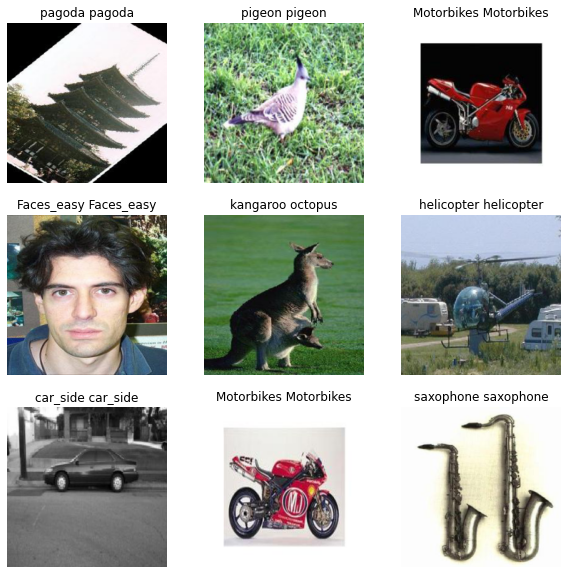

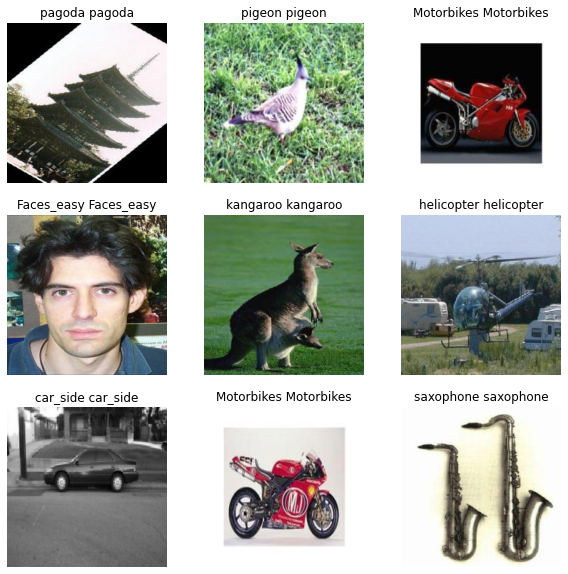

In [ ]:
a_batch = next(iter(test_data))
plot_results(a_batch, net, model_cnn_robust, True)

In [ ]:
total = 0
correct_normal = 0
correct_robust = 0
net.cuda()
model_cnn_robust.cuda()
net.eval()
model_cnn_robust.eval()

for i, data in enumerate(test_data, 0): # Obtener batch
  inputs = data[0].float().cuda()
  labels = data[1]
  total += len(inputs)
  
  for i in range(len(inputs)):
    image = inputs[i]
    label = labels[i].cuda()
    inputs[i] += pgd_linf(net, image.unsqueeze(0), label.unsqueeze(0), epsilon = 0.2, alpha = 0.025, num_iter=8).squeeze(0)

  
  with torch.no_grad():
    norm_outputs = net(inputs)
    _, norm_predicted = torch.max(norm_outputs.data, 1)
    adv_outputs = model_cnn_robust(inputs)
    _, adv_predicted = torch.max(adv_outputs.data, 1)
  
  for i in range(len(norm_predicted)):
    if norm_predicted[i].item() == labels[i].item():
      correct_normal += 1

    if adv_predicted[i].item() == labels[i].item():
      correct_robust += 1

In [ ]:
print(f'Correctos modelo normal: {correct_normal}, Porcentaje: {correct_normal/total}')
print(f'Correctos modelo robust: {correct_robust}, Porcentaje: {correct_robust/total}')

Correctos modelo normal: 828, Porcentaje: 0.8313253012048193
Correctos modelo robust: 734, Porcentaje: 0.7369477911646586
